In [19]:
import numpy as np
from skimage import io
from pathlib import Path
import re
import ants
from skimage.transform import resize
from tqdm import tqdm
from skimage.morphology import skeletonize_3d, binary_closing
from scipy.ndimage import distance_transform_edt, binary_dilation
import tifffile as tif
from scipy.ndimage import binary_fill_holes
import cc3d
from scipy.io import loadmat, savemat
import sknw
import networkx as nx
import pickle
import os
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy as sp
import vg
from pytransform3d.rotations import matrix_from_axis_angle
import multiprocessing
from scipy.ndimage import convolve as conv
from scipy.stats import multivariate_normal
from skimage import color, data, restoration
from RedLionfishDeconv import doRLDeconvolutionFromNpArrays
from matplotlib.patches import Circle
from skimage.feature import peak_local_max
from statistics import mode
import imageio
from PIL import Image
from PIL.TiffTags import TAGS
from tifffile import TiffFile
from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score
import seaborn as sns
from sklearn.linear_model import LinearRegression
from matplotlib.colors import LinearSegmentedColormap


In [20]:
mouse_ids_path = Path('matt_raw_warped')#each mouse has its own folder with raw data in it
mouse_ids = list(mouse_ids_path.glob('*res*.tif'))#grab folder names/mouse ids
mouse_ids = sorted([x.as_posix() for x in mouse_ids])
data_dicts = [
    {"image":image_name}
    for image_name in mouse_ids
]

#data_dicts = [data_dicts[_i]]
re.sub('matt_raw_warped_upsampled','matt_preds_registered',data_dicts[0]["image"])

'matt_raw_warped/06162021_45-XYZres288_0001_warped.tif'

# Define connected componnet removal

In [4]:
def remove_small_comps_3d(image, thresh = 500):
    """

    Parameters
    ----------
    image : binary np array with uint8 elements
        3d numpy matrix, connected components will be removed form this image
    thresh : int64
        smallest connected components to keep

    Returns
    -------
    np.array with uint8 elements, binary
        binary image with connected components below the threshold removed.

    """
    img_lab, N = cc3d.connected_components(image,return_N=True)
    unique, counts = np.unique(img_lab, return_counts=True)
    unique_keep = unique[counts>thresh]
    unique_keep = np.delete(unique_keep,[0])
    img_filt = np.zeros(img_lab.shape).astype('int8')
    img_filt[np.isin(img_lab,unique_keep)] = 1
    return img_filt.astype('uint8')   

def fill_holes(img,thresh=1000):
    #res = np.zeros(img.shape)
    for i in np.unique(img)[::-1]:
        _tmp = (img==i)*1.0
        _tmp = _tmp.astype('int8')
        _tmp = remove_small_comps_3d(_tmp,thresh=thresh)
        img[_tmp==1] = i
    res = img.astype('int8')
    return res

def _rotmat(vector, points):
    """
    Rotates a 3xn array of 3D coordinates from the +z normal to an
    arbitrary new normal vector.
    """
    
    vector = vg.normalize(vector)
    axis = vg.perpendicular(vg.basis.z, vector)
    angle = vg.angle(vg.basis.z, vector, units='rad')
    
    a = np.hstack((axis, (angle,)))
    R = matrix_from_axis_angle(a)
    
    r = sp.spatial.transform.Rotation.from_matrix(R)
    rotmat = r.apply(points)
    
    return rotmat

def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    if np.min(dist_2)>10:
        return node
    else:
        return nodes[np.argmin(dist_2)]

In [5]:
exclude = ['XYZres103',
           'XYZres104',
           'XYZres105',
           'XYZres105',
           'XYZres107',
           'XYZres133',
           'XYZres134',
           'XYZres135',
           'XYZres136',
           'XYZres137',
           'XYZres138',
           'XYZres139',
           'XYZres140',
           'XYZres183',
           'XYZres196',
           'XYZres197',
           'XYZres260',
           'XYZres288',
           'XYZres343',
           'XYZres340',
           'XYZres341',
           'XYZres250',
           'XYZres297',
           'XYZres295',
           'XYZres457',
           'XYZres455']

In [6]:
xls = pd.ExcelFile('TBI_STIM_metalog_local.xlsx')
xls2 = pd.ExcelFile('../TBI_monai_UNET/p3_metalog.xlsx')
df = {}
for sheet_name in xls.sheet_names:
    df[sheet_name] = xls.parse(sheet_name)
for sheet_name in xls2.sheet_names:
    df[sheet_name] = xls2.parse(sheet_name)

In [7]:
dic = {}
for key in df.keys():
    if '3D' in key and ('vbm01' not in key and 'vbm02' not in key and 'SHAM7_3D' not in key and 'TBI45_3D' not in key and 'TBI11_3D' not in key and 'TBI65_3D' not in key and 'TBI22_3D' not in key and 'TBI28_3D' not in key and 'TBI40_3D' not in key and 'TBI51_3D' not in key and 'TBI70_3D' not in key):
        if 'vbm' not in key:
            addition = re.sub('TBI','',re.sub('SHAM','',re.sub('_3D','',key)))
        else:
            addition = ''
        df[key] = df[key][~df[key][df[key].columns[1]].isin(exclude)]
        scans = np.array(df[key][df[key].columns[1]])
        scans = [x for x in scans if 'res' in str(x)]
        bottoms_1 = df[key][df[key][df[key].columns[3]] == 500]
        bottoms_2 = df[key][df[key][df[key].columns[2]] == 500]
        bottoms = pd.concat((bottoms_1,bottoms_2))
        bottoms = np.array(bottoms[bottoms.columns[1]])
        bottoms = [addition + '-' + x for x in bottoms]
        bottoms = [x for x in bottoms if 'res' in x]
        tops_1 = df[key][df[key][df[key].columns[3]] == 0]
        tops_2 = df[key][df[key][df[key].columns[2]] == 0]
        tops = pd.concat((tops_1,tops_2))
        tops = np.array(tops[tops.columns[1]])
        tops = [addition + '-' + x for x in tops]
        tops = [x for x in tops if 'res' in x]
        if len(tops) > 1:
            dic[tops[0]] = list(tops[1:])
        elif len(tops) == 1:
            dic[tops[0]] = tops
        if len(bottoms) > 1:
            dic[bottoms[0]] = list(bottoms[1:])
        elif len(bottoms) == 1:
            dic[bottoms[0]] = bottoms
dic_2 = {'45-XYZres290':['45-XYZres296'],
         '45-XYZres297':['45-XYZres295'],
         '45-XYZres294':['45-XYZres298'],
         '45-XYZres288':['45-XYZres300'],
         '11-XYZres95':['11-XYZres98','11-XYZres102'],
         '11-XYZres92':[],
         '11-XYZres93':['11-XYZres93','11-XYZres96','11-XYZres97','11-XYZres100','11-XYZres101'],
         '11-XYZres91':['11-XYZres94','11-XYZres99'],
         '22-XYZres164':['22-XYZres165','22-XYZres168','22-XYZres169'],
         '22-XYZres160':['22-XYZres161'],
         '22-XYZres163':['22-XYZres166','22-XYZres167','22-XYZres170'],
         '22-XYZres159':['22-XYZres162'],
         '28-XYZres184':['28-XYZres185'],
         '28-XYZres188':['28-XYZres189','28-XYZres193','28-XYZres194'],
         '28-XYZres186':['28-XYZres187','28-XYZres188','28-XYZres190','28-XYZres191','28-XYZres192','28-XYZres195'],
         '28-XYZres183':[],
         '40-XYZres248':['40-XYZres249'],
         '40-XYZres245':['40-XYZres252'],
         '40-XYZres244':[],
         '40-XYZres243':['40-XYZres246','40-XYZres247','40-XYZres251'],
         '51-XYZres297':['51-XYZres298','51-XYZres302','51-XYZres305','51-XYZres301'],
         '51-XYZres296':['51-XYZres306'],
         '51-XYZres299':['51-XYZres300','51-XYZres303','51-XYZres304'],
         '65-XYZres397':['65-XYZres398','65-XYZres401','65-XYZres402','65-XYZres405','65-XYZres408','65-XYZres409'],
         '65-XYZres396':['65-XYZres399','65-XYZres400'],
         '65-XYZres403':[],
         '70-XYZres420':['70-XYZres421','70-XYZres422'],
         '70-XYZres419':['70-XYZres416','70-XYZres413','70-XYZres410','70-XYZres412','70-XYZres416'],
         '70-XYZres414':['70-XYZres417'],
         '70-XYZres411':['70-XYZres418','70-XYZres415'],
         '-XYZres007':[]
        }
dic.update(dic_2) 
len(list(dic.keys()))

119

In [8]:
directory = Path('matt_raw_warped_single_upsampled_seg')
files = directory.glob('*_warped.pickle')
files = sorted([x.as_posix() for x in files])
files = [x for x in files if '-' in x]
#files = [x for x in files if not os.path.exists(re.sub('_warped.pickle','_changes_2.npz',re.sub('matt_raw_warped_single_upsampled_seg','simulated_changes',x)))]
np.random.shuffle(files)
print(len(files))
print(files[0])

823
matt_raw_warped_single_upsampled_seg/20220617_70-XYZres413_0001_warped.pickle


In [8]:
min_prob = 0.75
max_var = 0.1
sampling = 1/5

for file in tqdm(files):
    if not os.path.exists(re.sub('_warped.pickle','_changes_2.npz',re.sub('matt_raw_warped_single_upsampled_seg','simulated_changes',file))):
        graph = nx.read_gpickle(file)
        _res_radii = []
        _res_radii_std = []
        _res_radii_r = []
        _res_radii_r_std = []
        _zoom = []
        if len(graph.edges) < 1500 and len(graph.edges) > 30:
            for sheet_name in xls.sheet_names + xls2.sheet_names:
                if re.sub('_0001','',re.sub('matt_raw_warped_single_upsampled_seg/','',re.sub('_warped.pickle','',re.sub('xyz','XYZ',file))).split('-')[1]) in df[sheet_name].values:
                    subj = sheet_name
                    if (re.sub('matt_raw_warped_single_upsampled_seg/','',re.sub('_warped.pickle','',file)).split('-')[0].split(' ') + [''])[0] in sheet_name or (re.sub('matt_raw_warped_single_upsampled_seg/','',re.sub('_warped.pickle','',file)).split('-')[0].split('_') + [''])[1] in sheet_name:
                        _tmp = df[subj].loc[df[subj]['CHECK WATER'] ==  re.sub('_0001','',re.sub('matt_preds/','',re.sub('_warped.pickle','',re.sub('xyz','XYZ',file))).split('-')[1])]
                        if _tmp['Unnamed: 12'].iloc[0] == 'raster':
                            img_file = re.sub('matt_raw_warped_single_upsampled_seg','matt_raw_warped_single',re.sub('_warped.pickle','_warped.tif',file))
                            seg_file = re.sub('_warped.pickle','_warped_seg.npy',file)
                            mean_file = re.sub('_upsampled_seg','_upsampled',re.sub('_warped.pickle','_warped_mean.npy',file))
                            std_file = re.sub('_upsampled_seg','_upsampled',re.sub('_warped.pickle','_warped_2x_std.npy',file))
                            img = io.imread(img_file)
                            img_ch2 = sp.ndimage.zoom(np.swapaxes(img[:,1,:,:],0,2),(1,1,2.645833333))
                            img = sp.ndimage.zoom(np.swapaxes(img[:,0,:,:],0,2),(1,1,2.645833333))
                            seg = np.load(seg_file)
                            mean = np.load(mean_file)
                            std = np.load(std_file)
                            seg_dst = distance_transform_edt(seg)
                            nrn_dst = np.load(re.sub('_warped.pickle','_warped_seg_nrn_dst.npy',file))
                            wavelength = _tmp['Unnamed: 11'].iloc[0]
                            power_per = _tmp['Unnamed: 10'].iloc[0]
                            start_depth = _tmp['Unnamed: 2'].iloc[0]
                            a, b, c = np.mgrid[-15:16:1, -15:16:1, -15:16:1]
                            abc = np.dstack([a.flat,b.flat, c.flat])
                            mu = np.array([0,0,0])
                            sigma = np.array([0.636,0.127,0.127])
                            covariance = np.diag(sigma**2)
                            d = multivariate_normal.pdf(abc, mean=mu, cov=covariance)
                            d = d.reshape((len(a),len(b),len(c)))
                            deconv_img = np.copy(img)
                            deconv_img =  1023 * restoration.richardson_lucy(img/1023.0, d, iterations=10) - 1023 * restoration.richardson_lucy(img_ch2/1023.0, d, iterations=10)
                            deconv_img = np.int16(deconv_img)
                            for i in np.random.choice(range(len(graph.edges)),30):
                                path = graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['pts']
                                _pred_radii = np.mean(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
                                if len(path) > 8:
                                    _pred_radii_max = np.max(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
                                    if _pred_radii == 0:
                                        _pred_radii =1
                                    
                                    _box_fit = max([np.int16(_pred_radii_max)+10, 15])
                                    path_smooth = np.float32(np.copy(path))
                                    for k in range(len(path[0])):
                                        path_smooth[:,k] = sp.ndimage.gaussian_filter1d(np.float64(path[:,k]),3,mode='nearest')
                                    path_grad = np.gradient(path_smooth,edge_order=2)[0]
                                    res_fwhm = []
                                    X = np.arange(-1*_box_fit,_box_fit+1,1)
                                    Y = np.arange(-1*_box_fit,_box_fit+1,1)
                                    x,y = np.meshgrid(X,Y)
                                    x = x.flatten()
                                    y = y.flatten()
                                    z = np.zeros(len(x))
                                    xy = np.vstack([x,y,z])
                                    
                                    
                                    res_fwhm = []
                                    
                                    res_fwhm_sigma = []
                                    
                                    def calc_fwhm_path(I):
                                        point_grad = path_grad[I]
                                        point = path[I]
                                        if all(point_grad[0:2] == [0,0]) and abs(point_grad[2]/point_grad[2]) == 1:
                                            rotated = xy.T + point
                                        else:
                                            rotated = _rotmat(point_grad,xy.T) + point
                                        points_img = sp.ndimage.map_coordinates(#np.int16(mean[1]*1024),
                                                                            deconv_img,
                                                                            rotated.T, 
                                                                            order=3,
                                                                            mode='constant')
                                               
                                        points_img = np.reshape(points_img,(len(X),len(Y)))
                                        np.random.seed()
                                        zoom = np.random.uniform(0.5,2)
                                        points_img_resized =  sp.ndimage.zoom(points_img,zoom, mode='nearest')
                                        points_img_no_smooth = np.copy(points_img)
                                        points_img = sp.ndimage.gaussian_filter(points_img, sigma = _pred_radii*.4)
                                        _rand = np.random.normal(1,0.1)
                                        points_img_resized_smooth = sp.ndimage.gaussian_filter(points_img_resized, sigma = _pred_radii*_rand*.4*zoom)
                                        
                                        _point = np.array(np.arange(0,_pred_radii+20,sampling))
                                        _zeros = np.zeros(len(_point))
                                        _point = np.array([_point,_zeros])
                                        _centre = closest_node([len(X)//2+1,len(Y)//2+1],peak_local_max(points_img.T))
                                        
                                        _res = []
                                        
                                        _point_r = np.array(np.arange(0,_pred_radii*zoom+20,sampling))
                                        _zeros_r = np.zeros(len(_point_r))
                                        _point_r = np.array([_point_r,_zeros_r])
                                        _centre_r = closest_node([len(points_img_resized_smooth)//2+1,len(points_img_resized_smooth)//2+1],peak_local_max(points_img_resized_smooth.T))
                                        
                                        _res = []
                                        _res_r = []
                                        
                                        for deg in np.arange(0,360,10):
                                            rot_point = np.dot(np.array([[np.cos(np.deg2rad(deg)),-1*np.sin(np.deg2rad(deg))],[np.sin(np.deg2rad(deg)),np.cos(np.deg2rad(deg))]]),_point)
                                            rot_point[0] = rot_point[0] + _centre[0]
                                            rot_point[1] = rot_point[1] + _centre[1]
                                            points_vals = sp.ndimage.map_coordinates(points_img.T,
                                                                                     rot_point, 
                                                                                     order=3,
                                                                                     cval=0)
                                            points_vals = sp.ndimage.gaussian_filter1d(points_vals,sigma=_pred_radii*.4/sampling)
                                            points_vals_grad = np.gradient(points_vals)
                                            _ = np.array(sp.signal.argrelextrema(points_vals + np.random.uniform(-1e-5,1e-5,len(points_vals)),np.less,order=3))
                                            if _.shape[1] != 0:
                                                points_vals_grad = np.gradient(points_vals[:_[0,0]+3])
                                                _ = np.argmin(points_vals_grad)
                                                _res.append(_*sampling)
                                            else:
                                                points_vals_grad = np.gradient(points_vals)
                                                _ = np.argmin(points_vals_grad)
                                                _res.append(_*sampling)
                                        for deg in np.arange(0,360,10):
                                            rot_point_r = np.dot(np.array([[np.cos(np.deg2rad(deg)),-1*np.sin(np.deg2rad(deg))],[np.sin(np.deg2rad(deg)),np.cos(np.deg2rad(deg))]]),_point_r)
                                            rot_point_r[0] = rot_point_r[0] + _centre_r[0]
                                            rot_point_r[1] = rot_point_r[1] + _centre_r[1]
                                            points_vals = sp.ndimage.map_coordinates(points_img_resized_smooth.T,
                                                                                     rot_point_r, 
                                                                                     order=3,
                                                                                     cval=0)
                                            points_vals = sp.ndimage.gaussian_filter1d(points_vals,sigma = _pred_radii*_rand*.4*zoom/sampling)
                                            points_vals_grad = np.gradient(points_vals)
                                            _ = np.array(sp.signal.argrelextrema(points_vals + np.random.uniform(-1e-5,1e-5,len(points_vals)),np.less,order=3))
                                            if _.shape[1] != 0:
                                                points_vals_grad = np.gradient(points_vals[:_[0,0]+3])
                                                _ = np.argmin(points_vals_grad)
                                                _res_r.append(_*sampling)
                                            else:
                                                points_vals_grad = np.gradient(points_vals)
                                                _ = np.argmin(points_vals_grad)
                                                _res_r.append(_*sampling)
                                        _res = np.array(_res)
                                        _res_r = np.array(_res_r)
                                        _res = _res[np.where(_res!=0)]
                                        _res_r = _res_r[np.where(_res_r!=0)]
                                        _mean = np.mean(_res)
                                        _std = np.std(_res)
                                        _mean_r = np.mean(_res_r)
                                        _std_r = np.std(_res_r)
                                        _mask = np.where(np.logical_and(_res>_mean-2*_std, _res<_mean+2*_std))
                                        _mask_r = np.where(np.logical_and(_res_r>_mean_r-2*_std_r, _res_r<_mean_r+2*_std_r))
                                        _res = _res[_mask]
                                        _res_r = _res_r[_mask_r]
                                        radii = np.mean(_res)
                                        radii_std = np.std(_res)
                                        radii_r = np.mean(_res_r)
                                        radii_std_r = np.std(_res_r)
                                        return radii, radii_std, radii_r, radii_std_r, zoom
                                    
                                    pool = multiprocessing.Pool(8)
                                    _vals, _vals_sigma, _vals_r, _vals_sigma_r, zoom = zip(*pool.map(calc_fwhm_path, np.random.choice(range(len(path)),8)))
                                    _res_radii.extend(list(_vals))
                                    _res_radii_std.extend(list(_vals_sigma))
                                    _res_radii_r.extend(list(_vals_r))
                                    _res_radii_r_std.extend(list(_vals_sigma_r))
                                    _zoom.extend(list(zoom))
                            np.savez(
                                re.sub('_warped.pickle','_changes_2.npz',re.sub('matt_raw_warped_single_upsampled_seg','simulated_changes',file)),
                                _res_radii = _res_radii,
                                _res_radii_std = _res_radii_std,
                                _res_radii_r = _res_radii_r,
                                _res_radii_r_std = _res_radii_r_std,
                                _zoom = _zoom
                            )

  1%|          | 8/823 [00:04<07:07,  1.91it/s]


KeyboardInterrupt: 

In [ ]:
_rand
#_pred_radii_r = np.random.normal(scale=0.1) * _pred_radii
points_vals = sp.ndimage.gaussian_filter1d(points_vals,sigma=_pred_radii_r*zoom*.4/sampling)

In [15]:
_rand = 0.1
print(_rand)
_rand = np.random.normal(1,0.1)
print(_rand)

0.1
1.0452650724592683


In [ ]:
zoom

In [ ]:
_pred_radii_r*zoom*.4/sampling

In [ ]:
np.random.normal(scale=0.1) * _pred_radii

In [37]:
min_prob = 0.75
max_var = 0.1
sampling = 1/5

xls = pd.ExcelFile('TBI_STIM_metalog_local.xlsx')
xls2 = pd.ExcelFile('../TBI_monai_UNET/p3_metalog.xlsx')
df = {}
for sheet_name in xls.sheet_names:
    df[sheet_name] = xls.parse(sheet_name)
for sheet_name in xls2.sheet_names:
    df[sheet_name] = xls2.parse(sheet_name)
np.random.shuffle(files)
for file in tqdm(files):
    #if not os.path.exists(re.sub('_warped.pickle','_changes.npz',re.sub('matt_raw_warped_single_upsampled_seg','simulated_changes',file))):
        graph = nx.read_gpickle(file)
        _res_radii = []
        _res_radii_std = []
        _res_radii_r = []
        _res_radii_r_std = []
        _zoom = []
        if len(graph.edges) < 1500 and len(graph.edges) > 30:
            for sheet_name in xls.sheet_names + xls2.sheet_names:
                if re.sub('_0001','',re.sub('matt_raw_warped_single_upsampled_seg/','',re.sub('_warped.pickle','',re.sub('xyz','XYZ',file))).split('-')[1]) in df[sheet_name].values:
                    subj = sheet_name
                    if (re.sub('matt_raw_warped_single_upsampled_seg/','',re.sub('_warped.pickle','',file)).split('-')[0].split(' ') + [''])[0] in sheet_name or (re.sub('matt_raw_warped_single_upsampled_seg/','',re.sub('_warped.pickle','',file)).split('-')[0].split('_') + [''])[1] in sheet_name:
                        _tmp = df[subj].loc[df[subj]['CHECK WATER'] ==  re.sub('_0001','',re.sub('matt_preds/','',re.sub('_warped.pickle','',re.sub('xyz','XYZ',file))).split('-')[1])]
                        if _tmp['Unnamed: 12'].iloc[0] == 'raster':
                            img_file = re.sub('matt_raw_warped_single_upsampled_seg','matt_raw_warped_single',re.sub('_warped.pickle','_warped.tif',file))
                            seg_file = re.sub('_warped.pickle','_warped_seg.npy',file)
                            mean_file = re.sub('_upsampled_seg','_upsampled',re.sub('_warped.pickle','_warped_mean.npy',file))
                            std_file = re.sub('_upsampled_seg','_upsampled',re.sub('_warped.pickle','_warped_2x_std.npy',file))
                            img = io.imread(img_file)
                            img_ch2 = sp.ndimage.zoom(np.swapaxes(img[:,1,:,:],0,2),(1,1,2.645833333))
                            img = sp.ndimage.zoom(np.swapaxes(img[:,0,:,:],0,2),(1,1,2.645833333))
                            seg = np.load(seg_file)
                            mean = np.load(mean_file)
                            std = np.load(std_file)
                            seg_dst = distance_transform_edt(seg)
                            nrn_dst = np.load(re.sub('_warped.pickle','_warped_seg_nrn_dst.npy',file))
                            wavelength = _tmp['Unnamed: 11'].iloc[0]
                            power_per = _tmp['Unnamed: 10'].iloc[0]
                            start_depth = _tmp['Unnamed: 2'].iloc[0]
                            a, b, c = np.mgrid[-15:16:1, -15:16:1, -15:16:1]
                            abc = np.dstack([a.flat,b.flat, c.flat])
                            mu = np.array([0,0,0])
                            sigma = np.array([0.636,0.127,0.127])
                            covariance = np.diag(sigma**2)
                            d = multivariate_normal.pdf(abc, mean=mu, cov=covariance)
                            d = d.reshape((len(a),len(b),len(c)))
                            deconv_img = np.copy(img)
                            deconv_img =  1023 * restoration.richardson_lucy(img/1023.0, d, iterations=10) - 1023 * restoration.richardson_lucy(img_ch2/1023.0, d, iterations=10)
                            deconv_img = np.int16(deconv_img)
                            for i in np.random.choice(range(len(graph.edges)),30):
                                path = graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['pts']
                                _pred_radii = np.mean(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
                                if len(path) > 8:
                                    _pred_radii_max = np.max(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
                                    if _pred_radii == 0:
                                        _pred_radii =1
                                    
                                    _box_fit = max([np.int16(_pred_radii_max)+10, 15])
                                    path_smooth = np.float32(np.copy(path))
                                    for k in range(len(path[0])):
                                        path_smooth[:,k] = sp.ndimage.gaussian_filter1d(np.float64(path[:,k]),3,mode='nearest')
                                    path_grad = np.gradient(path_smooth,edge_order=2)[0]
                                    res_fwhm = []
                                    X = np.arange(-1*_box_fit,_box_fit+1,1)
                                    Y = np.arange(-1*_box_fit,_box_fit+1,1)
                                    x,y = np.meshgrid(X,Y)
                                    x = x.flatten()
                                    y = y.flatten()
                                    z = np.zeros(len(x))
                                    xy = np.vstack([x,y,z])
                                    
                                    
                                    res_fwhm = []
                                    
                                    res_fwhm_sigma = []
                                    for I in np.random.choice(range(len(path)),8):
                                    #def calc_fwhm_path(I):
                                        point_grad = path_grad[I]
                                        point = path[I]
                                        if all(point_grad[0:2] == [0,0]) and abs(point_grad[2]/point_grad[2]) == 1:
                                            rotated = xy.T + point
                                        else:
                                            rotated = _rotmat(point_grad,xy.T) + point
                                        points_img = sp.ndimage.map_coordinates(#np.int16(mean[1]*1024),
                                                                            deconv_img,
                                                                            rotated.T, 
                                                                            order=3,
                                                                            mode='constant')
                                               
                                        points_img = np.reshape(points_img,(len(X),len(Y)))
                                        np.random.seed()
                                        zoom = np.random.uniform(0.5,2)
                                        points_img_resized =  sp.ndimage.zoom(points_img,zoom, mode='nearest')
                                        points_img_no_smooth = np.copy(points_img)
                                        points_img = sp.ndimage.gaussian_filter(points_img, sigma = _pred_radii*.4)
                                        points_img_resized_smooth = sp.ndimage.gaussian_filter(points_img_resized, sigma = _pred_radii*.4*zoom)
                                        
                                        _point = np.array(np.arange(0,_pred_radii+20,sampling))
                                        _zeros = np.zeros(len(_point))
                                        _point = np.array([_point,_zeros])
                                        _centre = closest_node([len(X)//2+1,len(Y)//2+1],peak_local_max(points_img.T))
                                        
                                        _res = []
                                        
                                        _point_r = np.array(np.arange(0,_pred_radii*zoom+20,sampling))
                                        _zeros_r = np.zeros(len(_point_r))
                                        _point_r = np.array([_point_r,_zeros_r])
                                        _centre_r = closest_node([len(points_img_resized_smooth)//2+1,len(points_img_resized_smooth)//2+1],peak_local_max(points_img_resized_smooth.T))
                                        
                                        _res = []
                                        _res_r = []
                                        
                                        for deg in np.arange(0,360,10):
                                            rot_point = np.dot(np.array([[np.cos(np.deg2rad(deg)),-1*np.sin(np.deg2rad(deg))],[np.sin(np.deg2rad(deg)),np.cos(np.deg2rad(deg))]]),_point)
                                            rot_point[0] = rot_point[0] + _centre[0]
                                            rot_point[1] = rot_point[1] + _centre[1]
                                            points_vals = sp.ndimage.map_coordinates(points_img.T,
                                                                                     rot_point, 
                                                                                     order=3,
                                                                                     cval=0)
                                            points_vals = sp.ndimage.gaussian_filter1d(points_vals,sigma=_pred_radii*.4/sampling)
                                            points_vals_grad = np.gradient(points_vals)
                                            _ = np.array(sp.signal.argrelextrema(points_vals + np.random.uniform(-1e-5,1e-5,len(points_vals)),np.less,order=3))
                                            if _.shape[1] != 0:
                                                points_vals_grad = np.gradient(points_vals[:_[0,0]+3])
                                                _ = np.argmin(points_vals_grad)
                                                _res.append(_*sampling)
                                            else:
                                                points_vals_grad = np.gradient(points_vals)
                                                _ = np.argmin(points_vals_grad)
                                                _res.append(_*sampling)
                                        for deg in np.arange(0,360,10):
                                            rot_point_r = np.dot(np.array([[np.cos(np.deg2rad(deg)),-1*np.sin(np.deg2rad(deg))],[np.sin(np.deg2rad(deg)),np.cos(np.deg2rad(deg))]]),_point_r)
                                            rot_point_r[0] = rot_point_r[0] + _centre_r[0]
                                            rot_point_r[1] = rot_point_r[1] + _centre_r[1]
                                            points_vals = sp.ndimage.map_coordinates(points_img_resized_smooth.T,
                                                                                     rot_point_r, 
                                                                                     order=3,
                                                                                     cval=0)
                                            points_vals = sp.ndimage.gaussian_filter1d(points_vals,sigma=_pred_radii*zoom*.4/sampling)
                                            points_vals_grad = np.gradient(points_vals)
                                            _ = np.array(sp.signal.argrelextrema(points_vals + np.random.uniform(-1e-5,1e-5,len(points_vals)),np.less,order=3))
                                            if _.shape[1] != 0:
                                                points_vals_grad = np.gradient(points_vals[:_[0,0]+3])
                                                _ = np.argmin(points_vals_grad)
                                                _res_r.append(_*sampling)
                                            else:
                                                points_vals_grad = np.gradient(points_vals)
                                                _ = np.argmin(points_vals_grad)
                                                _res_r.append(_*sampling)
                                        _res = np.array(_res)
                                        _res_r = np.array(_res_r)
                                        _res = _res[np.where(_res!=0)]
                                        _res_r = _res_r[np.where(_res_r!=0)]
                                        _mean = np.mean(_res)
                                        _std = np.std(_res)
                                        _mean_r = np.mean(_res_r)
                                        _std_r = np.std(_res_r)
                                        _mask = np.where(np.logical_and(_res>_mean-2*_std, _res<_mean+2*_std))
                                        _mask_r = np.where(np.logical_and(_res_r>_mean_r-2*_std_r, _res_r<_mean_r+2*_std_r))
                                        _res = _res[_mask]
                                        _res_r = _res_r[_mask_r]
                                        radii = np.mean(_res)
                                        radii_std = np.std(_res)
                                        radii_r = np.mean(_res_r)
                                        radii_std_r = np.std(_res_r)
                                        #return radii, radii_std, radii_r, radii_std_r, zoom
                                    
                                    #pool = multiprocessing.Pool(8)
                                    #_vals, _vals_sigma, _vals_r, _vals_sigma_r, zoom = zip(*pool.map(calc_fwhm_path, np.random.choice(range(len(path)),8)))
                                    #_res_radii.extend(list(_vals))
                                    #_res_radii_std.extend(list(_vals_sigma))
                                    #_res_radii_r.extend(list(_vals_r))
                                    #_res_radii_r_std.extend(list(_vals_sigma_r))
                                    #_zoom.extend(list(zoom))
                                    break
        break
                            #np.savez(
                            #    re.sub('_warped.pickle','_changes.npz',re.sub('matt_raw_warped_single_upsampled_seg','simulated_changes',file)),
                            #    _res_radii = _res_radii,
                            #    _res_radii_std = _res_radii_std,
                            #    _res_radii_r = _res_radii_r,
                            #    _res_radii_r_std = _res_radii_r_std,
                            #    _zoom = _zoom
                            #)

  0%|          | 0/823 [00:00<?, ?it/s]/tmp/ipykernel_1964661/2497675361.py:51: FutureWarning:

`iterations` is a deprecated argument name for `richardson_lucy`. It will be removed in version 1.0. Please use `num_iter` instead.

  0%|          | 0/823 [03:46<?, ?it/s]


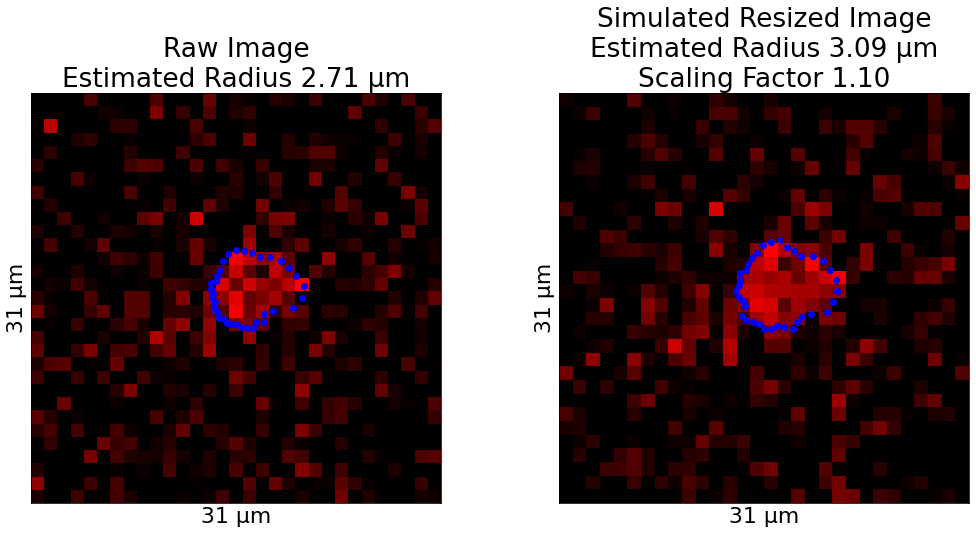

In [40]:
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = [15, 7.5]
colors = [(0, 0, 0), (1, 0, 0)] # first color is black, last is red
cm = LinearSegmentedColormap.from_list(
        "Custom", colors, N=1023)

fig, ax = plt.subplots(nrows=1,ncols=2)

# Hide X and Y axes label marks
ax[0].xaxis.set_tick_params(labelbottom=False)
ax[0].yaxis.set_tick_params(labelleft=False)

# Hide X and Y axes tick marks
ax[0].set_xticks([])
ax[0].set_yticks([])

# Hide X and Y axes label marks
ax[1].xaxis.set_tick_params(labelbottom=False)
ax[1].yaxis.set_tick_params(labelleft=False)

# Hide X and Y axes tick marks
ax[1].set_xticks([])
ax[1].set_yticks([])


for i in np.random.choice(range(len(graph.edges)),30):
    path = graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['pts']
    _pred_radii = np.mean(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
    if len(path) > 8:
        _pred_radii_max = np.max(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
        if _pred_radii == 0:
            _pred_radii =1
        
        _box_fit = max([np.int16(_pred_radii_max)+10, 15])
        path_smooth = np.float32(np.copy(path))
        for k in range(len(path[0])):
            path_smooth[:,k] = sp.ndimage.gaussian_filter1d(np.float64(path[:,k]),3,mode='nearest')
        path_grad = np.gradient(path_smooth,edge_order=2)[0]
        res_fwhm = []
        X = np.arange(-1*_box_fit,_box_fit+1,1)
        Y = np.arange(-1*_box_fit,_box_fit+1,1)
        x,y = np.meshgrid(X,Y)
        x = x.flatten()
        y = y.flatten()
        z = np.zeros(len(x))
        xy = np.vstack([x,y,z])
        
        
        res_fwhm = []
        
        res_fwhm_sigma = []
        for I in np.random.choice(range(len(path)),8):
        #def calc_fwhm_path(I):
            point_grad = path_grad[I]
            point = path[I]
            if all(point_grad[0:2] == [0,0]) and abs(point_grad[2]/point_grad[2]) == 1:
                rotated = xy.T + point
            else:
                rotated = _rotmat(point_grad,xy.T) + point
            points_img = sp.ndimage.map_coordinates(#np.int16(mean[1]*1024),
                                                deconv_img,
                                                rotated.T, 
                                                order=3,
                                                mode='constant')
                   
            points_img = np.reshape(points_img,(len(X),len(Y)))
            np.random.seed()
            zoom = 1.1#np.random.uniform(0.5,2)
            points_img_resized =  sp.ndimage.zoom(points_img,zoom, mode='nearest')
            points_img_no_smooth = np.copy(points_img)
            points_img = sp.ndimage.gaussian_filter(points_img, sigma = _pred_radii*.4)
            points_img_resized_smooth = sp.ndimage.gaussian_filter(points_img_resized, sigma = _pred_radii*.4*zoom)
            points_img_copy = np.copy(points_img)
            points_img_no_smooth[points_img_no_smooth<0] = 0
            L1 = len(points_img_resized)//2 
            L2 = len(points_img_no_smooth)//2
            if len(points_img_no_smooth) <= len(points_img_resized):
                length = len(points_img_no_smooth)
                ax[0].imshow(points_img_no_smooth, cmap=cm)
                ax[1].imshow(points_img_resized[L1-L2:L1+L2,L1-L2:L1+L2],cmap=cm, vmin=0, vmax = np.max(points_img_resized))
                points_img_resized = points_img_resized[L1-L2:L1+L2,L1-L2:L1+L2]
                points_img_resized_smooth = points_img_resized_smooth[L1-L2:L1+L2,L1-L2:L1+L2]
            else:
                length = len(points_img_resized)
                ax[0].imshow(points_img_no_smooth[L2-L1:L2+L1,L2-L1:L2+L1], cmap=cm)
                ax[1].imshow(points_img_resized,cmap=cm, vmin=0, vmax = np.max(points_img_resized))
                points_img_no_smooth = points_img_no_smooth[L2-L1:L2+L1,L2-L1:L2+L1]
                points_img = points_img[L2-L1:L2+L1,L2-L1:L2+L1]
                
            _point = np.array(np.arange(0,_pred_radii+20,sampling))
            _zeros = np.zeros(len(_point))
            _point = np.array([_point,_zeros])
            _centre = closest_node([len(points_img)//2+1,len(points_img)//2+1],peak_local_max(points_img.T))
            
            _res = []
            
            _point_r = np.array(np.arange(0,_pred_radii*zoom+20,sampling))
            _zeros_r = np.zeros(len(_point_r))
            _point_r = np.array([_point_r,_zeros_r])
            _centre_r = closest_node([len(points_img_resized_smooth)//2+1,len(points_img_resized_smooth)//2+1],peak_local_max(points_img_resized_smooth.T))
            
            _res = []
            _res_r = []
            
            for deg in np.arange(0,360,10):
                rot_point = np.dot(np.array([[np.cos(np.deg2rad(deg)),-1*np.sin(np.deg2rad(deg))],[np.sin(np.deg2rad(deg)),np.cos(np.deg2rad(deg))]]),_point)
                rot_point[0] = rot_point[0] + _centre[0]
                rot_point[1] = rot_point[1] + _centre[1]
                points_vals = sp.ndimage.map_coordinates(points_img.T,
                                                         rot_point, 
                                                         order=3,
                                                         cval=0)
                points_vals = sp.ndimage.gaussian_filter1d(points_vals,sigma=_pred_radii*.4/sampling)
                points_vals_grad = np.gradient(points_vals)
                _ = np.array(sp.signal.argrelextrema(points_vals + np.random.uniform(-1e-5,1e-5,len(points_vals)),np.less,order=3))
                if _.shape[1] != 0:
                    points_vals_grad = np.gradient(points_vals[:_[0,0]+3])
                    _ = np.argmin(points_vals_grad)
                    _res.append(_*sampling)
                    ax[0].scatter(_*sampling*np.cos(np.deg2rad(deg))+_centre[0],_*sampling*np.sin(np.deg2rad(deg))+_centre[1],color='b')
                else:
                    points_vals_grad = np.gradient(points_vals)
                    _ = np.argmin(points_vals_grad)
                    _res.append(_*sampling)
                    ax[0].scatter(_*sampling*np.cos(np.deg2rad(deg))+_centre[0],_*sampling*np.sin(np.deg2rad(deg))+_centre[1],color='b')
            for deg in np.arange(0,360,10):
                rot_point_r = np.dot(np.array([[np.cos(np.deg2rad(deg)),-1*np.sin(np.deg2rad(deg))],[np.sin(np.deg2rad(deg)),np.cos(np.deg2rad(deg))]]),_point_r)
                rot_point_r[0] = rot_point_r[0] + _centre_r[0]
                rot_point_r[1] = rot_point_r[1] + _centre_r[1]
                points_vals = sp.ndimage.map_coordinates(points_img_resized_smooth.T,
                                                         rot_point_r, 
                                                         order=3,
                                                         cval=0)
                points_vals = sp.ndimage.gaussian_filter1d(points_vals,sigma=_pred_radii*zoom*.4/sampling)
                points_vals_grad = np.gradient(points_vals)
                _ = np.array(sp.signal.argrelextrema(points_vals + np.random.uniform(-1e-5,1e-5,len(points_vals)),np.less,order=3))
                if _.shape[1] != 0:
                    points_vals_grad = np.gradient(points_vals[:_[0,0]+3])
                    _ = np.argmin(points_vals_grad)
                    _res_r.append(_*sampling)
                    ax[1].scatter(_*sampling*np.cos(np.deg2rad(deg))+_centre_r[0],_*sampling*np.sin(np.deg2rad(deg))+_centre_r[1],color='b')
                else:
                    points_vals_grad = np.gradient(points_vals)
                    _ = np.argmin(points_vals_grad)
                    _res_r.append(_*sampling)
                    ax[1].scatter(_*sampling*np.cos(np.deg2rad(deg))+_centre_r[0],_*sampling*np.sin(np.deg2rad(deg))+_centre_r[1],color='b')
            _res = np.array(_res)
            _res_r = np.array(_res_r)
            _res = _res[np.where(_res!=0)]
            _res_r = _res_r[np.where(_res_r!=0)]
            _mean = np.mean(_res)
            _std = np.std(_res)
            _mean_r = np.mean(_res_r)
            _std_r = np.std(_res_r)
            _mask = np.where(np.logical_and(_res>_mean-2*_std, _res<_mean+2*_std))
            _mask_r = np.where(np.logical_and(_res_r>_mean_r-2*_std_r, _res_r<_mean_r+2*_std_r))
            _res = _res[_mask]
            _res_r = _res_r[_mask_r]
            radii = np.mean(_res)
            radii_std = np.std(_res)
            radii_r = np.mean(_res_r)
            radii_std_r = np.std(_res_r)
            break
    break
ax[0].set_xlabel(F'{length} \u03BCm')
ax[0].set_ylabel(F'{length} \u03BCm')
ax[1].set_xlabel(F'{length} \u03BCm')
ax[1].set_ylabel(F'{length} \u03BCm')
ax[0].set_title(F'Raw Image\nEstimated Radius {radii:.02f} \u03BCm')
ax[1].set_title(F'Simulated Resized Image\nEstimated Radius {radii_r:.02f} \u03BCm\nScaling Factor {zoom:.02f}')
#fig.suptitle(F'Simulated Scaling Factor {zoom:.02f}')
fig.tight_layout()
fig.savefig('example_simulated_zoom.png')


In [90]:
#fig.suptitle(F'Simulated Scaling Factor {zoom:.02f}')
#fig.tight_layout()
fig.savefig('example_simulated_zoom.png')

TypeError: unsupported format string passed to numpy.ndarray.__format__

In [28]:
L1 = len(points_img_resized)//2 
L2 = len(points_img_no_smooth)//2

16

In [ ]:
points_img_resized_smooth.shape

In [9]:
files = Path('simulated_changes').glob('*_2.npz')
files = list(files)
files = sorted([x.as_posix() for x in files])

In [10]:
radii = []
radii_std = []
radii_r = []
radii_r_std = []
zoom = []
for file in tqdm(files):
    _tmp = np.load(file)
    radii.extend(list(_tmp['_res_radii']))
    radii_std.extend(list(_tmp['_res_radii_std']))
    radii_r.extend(list(_tmp['_res_radii_r']))
    radii_r_std.extend(list(_tmp['_res_radii_r_std']))
    zoom.extend(list(_tmp['_zoom']))

    
print(len(radii_r))
radii_r = np.array(radii_r)[np.isfinite(radii)]
radii_r_std = np.array(radii_r_std)[np.isfinite(radii)]
radii_std = np.array(radii_std)[np.isfinite(radii)]
zoom = np.array(zoom)[np.isfinite(radii)]
radii = np.array(radii)[np.isfinite(radii)]

radii_r_std = np.array(radii_r_std)[np.isfinite(radii_r)]
radii_std = np.array(radii_std)[np.isfinite(radii_r)]
zoom = np.array(zoom)[np.isfinite(radii_r)]
radii = np.array(radii)[np.isfinite(radii_r)]
radii_r = np.array(radii_r)[np.isfinite(radii_r)]
#radii = radii[~np.isnan(radii)]
print(len(radii_r)) 

#change_u05 = abs(radii * zoom - radii) < 0.2
#
#print(sum(change_u05))
#
#radii = radii[change_u05]
#radii_std = radii_std[change_u05]
#radii_r = radii_r[change_u05]
#radii_r_std = radii_r_std[change_u05]
#zoom = zoom[change_u05]

100%|██████████| 582/582 [00:29<00:00, 19.90it/s]


132984
132416


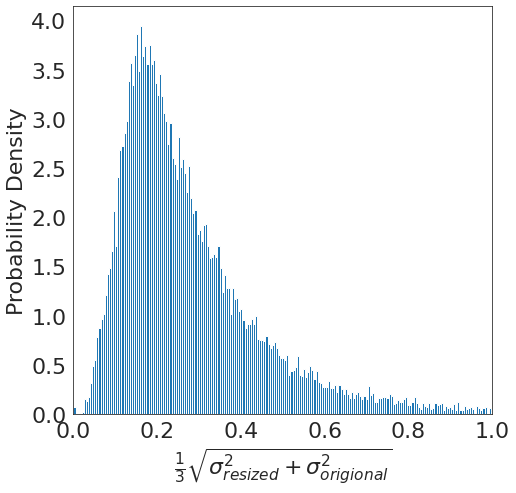

In [122]:
plt.hist(np.sqrt(radii_r_std**2 + zoom**2*radii_std**2)/3,bins=1000,density = 1)
plt.xlim(0,1)
plt.xlabel(r"$\frac{1}{3}\sqrt{\sigma^2_{resized}+\sigma^2_{origional}}$")
plt.ylabel('Probability Density')
plt.savefig('uncert_density.png')

In [113]:
np.mean(np.sqrt(radii_r_std**2 + zoom**2*radii_std**2)/3)

0.29648147007909353

In [93]:
sum(abs(radii_r - radii * zoom) < 0.5)

21303

In [111]:
sum(abs(radii_r - radii * zoom) < np.sqrt(radii_r_std**2 + zoom**2*radii_std**2)/3)/sum(change_u05)

0.7739673635900051

In [109]:
sum(abs(radii_r - radii * zoom) < np.sqrt(radii_r_std**2 + radii_std**2))/sum(change_u05)

0.9698708142104369

In [96]:
np.mean(np.sqrt(radii_r_std**2 + zoom**2*radii_std**2)/2)

0.4447222051186403

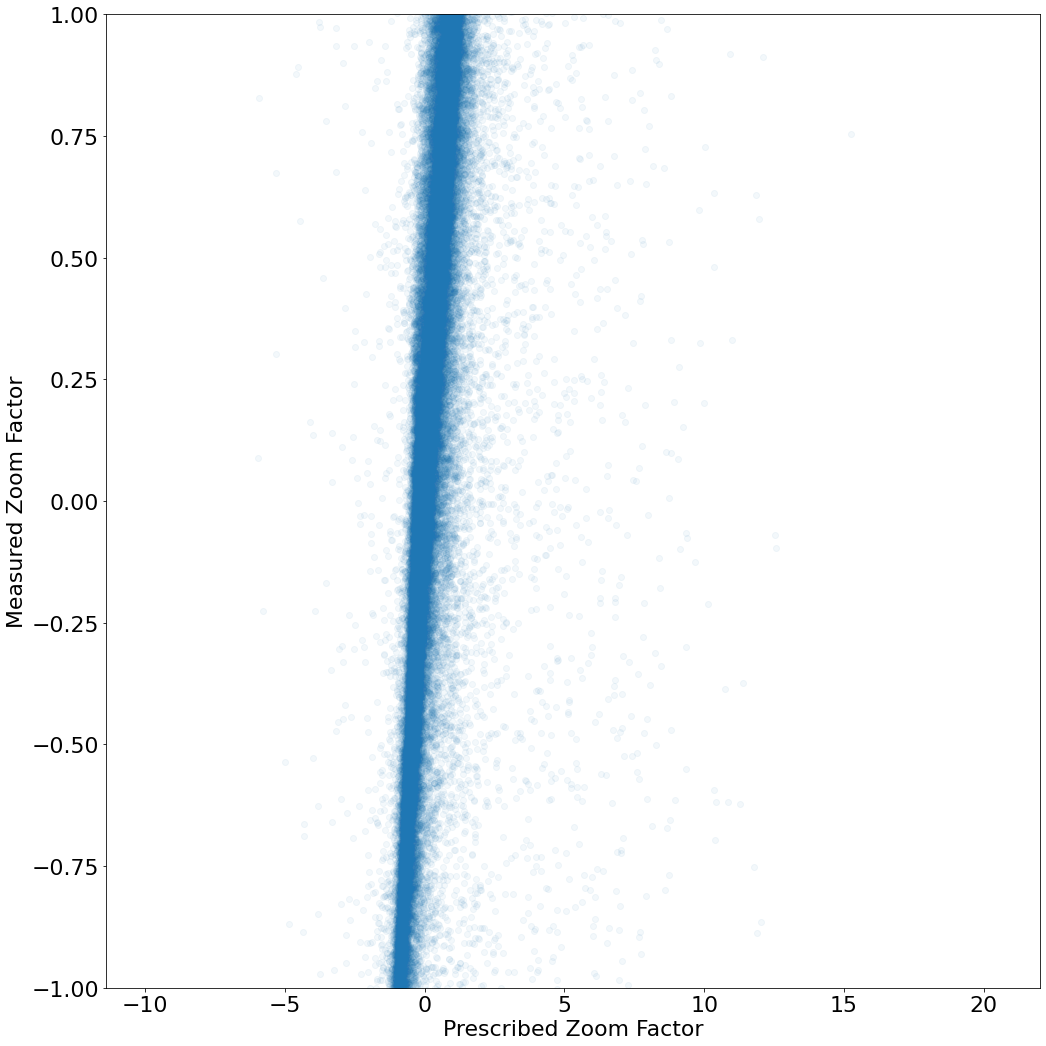

In [10]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams.update({'font.size': 22})

calc_zoom = np.array(radii_r)/np.array(radii)
calc_zoom_std = calc_zoom * (np.array(radii_std)/np.array(radii) + np.array(radii_r_std)/np.array(radii_r))

_zoom = zoom.reshape((-1,1))
model = LinearRegression().fit(_zoom,calc_zoom)
r_sq = model.score(_zoom,calc_zoom)


plt.clf()
plt.scatter(radii * zoom - radii,radii_r - radii, alpha=0.05)
plt.ylim(-1,1)
#plt.plot(np.arange(0.5,2,0.1),model.predict(np.arange(0.5,2,0.1).reshape(-1,1)),color='red')
plt.xlabel('Prescribed Zoom Factor')
plt.ylabel('Measured Zoom Factor')
plt.tight_layout()
plt.savefig('Simulated_diameter_changes.jpeg')
plt.show()


/tmp/ipykernel_409355/1203627465.py:13: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




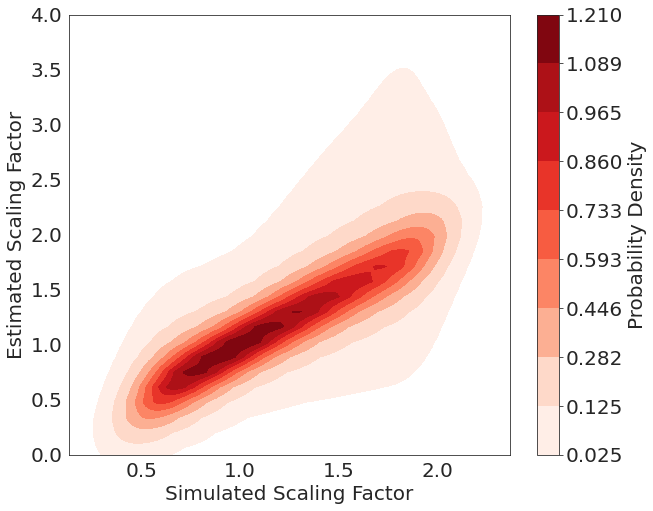

In [10]:
plt.rcParams['figure.figsize'] = [9.5, 7.5]
plt.rcParams.update({'font.size': 20})

calc_zoom = np.array(radii_r)/np.array(radii)
calc_zoom_std = calc_zoom * (np.array(radii_std)/np.array(radii) + np.array(radii_r_std)/np.array(radii_r))

_zoom = zoom.reshape((-1,1))
model = LinearRegression().fit(_zoom,calc_zoom)
r_sq = model.score(_zoom,calc_zoom)

sns.set_style("white")

sns.kdeplot(x = zoom,
            y = calc_zoom, 
            cmap="Reds", 
            shade=True, 
            bw_adjust=2,
            cbar=True,
            cbar_kws={'label': 'Probability Density'})
plt.ylim(0,4)
#plt.show()

#plt.clf()
##plt.scatter(zoom,calc_zoom, alpha=0.05)
#plt.ylim(0,3)
##plt.plot(np.arange(0.5,2,0.1),model.predict(np.arange(0.5,2,0.1).reshape(-1,1)),color='red')
plt.xlabel(r'Simulated Scaling Factor')
plt.ylabel(r'Estimated Scaling Factor')
plt.tight_layout()
plt.savefig('Simulated_diameter_changes.jpeg')
#plt.show()

In [15]:
np.sum(abs(zoom-calc_zoom)/calc_zoom_std < 1)/len(zoom)

/tmp/ipykernel_439721/546077798.py:1: RuntimeWarning:

divide by zero encountered in divide



0.973454869502175

In [ ]:
sns.kdeplot(x=zoom, y=calc_zoom, cmap="Reds", fill=True, bw_adjust=.5)
plt.ylim(0,3)
plt.show()


In [13]:
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(zoom, calc_zoom,alternative='greater')
print(r_value**2)

0.38378284715253025


In [14]:
from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(calc_zoom, zoom)
print(coefficient_of_dermination)

0.36523411378953463


In [16]:
corr_matrix = np.corrcoef(zoom, calc_zoom)
corr = corr_matrix[0,1]
R_sq = corr**2
 
print(R_sq)

0.38378284715253036


In [11]:
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(zoom*radii, radii_r,alternative='greater')
print(r_value**2)

0.6783838232314887


In [ ]:
plt.rcParams['figure.figsize'] = [9.5, 7.5]
plt.rcParams.update({'font.size': 20})

calc_zoom = np.array(radii_r)/np.array(radii)
calc_zoom_std = calc_zoom * (np.array(radii_std)/np.array(radii) + np.array(radii_r_std)/np.array(radii_r))

_zoom = zoom.reshape((-1,1))
model = LinearRegression().fit(_zoom,calc_zoom)
r_sq = model.score(_zoom,calc_zoom)

sns.set_style("white")

sns.kdeplot(x = zoom*radii,
            y = radii_r, 
            cmap="Reds", 
            shade=True, 
            bw_adjust=2,
            cbar=True,
            cbar_kws={'label': 'Probability Density'})
plt.ylim(0,13)
plt.xlim(0,12)
#plt.show()

#plt.clf()
##plt.scatter(zoom,calc_zoom, alpha=0.05)
#plt.ylim(0,3)
##plt.plot(np.arange(0.5,2,0.1),model.predict(np.arange(0.5,2,0.1).reshape(-1,1)),color='red')
plt.xlabel(r'Estimated Radius * Scaling factor')
plt.ylabel(r'Estimated Radius After Scaling')
plt.tight_layout()
plt.savefig('Simulated_diameter_changes.png')
#plt.show()

/tmp/ipykernel_1292675/214430565.py:13: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


